In [1]:
# Reinforcement Learning tutorial for three-level population transfer
# Copyright (C) 2021 Luigi Giannelli

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join("../src"))
if module_path not in sys.path:
    sys.path.append(module_path)

import copy

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# from qutip import basis, expect, ket2dm, mesolve
from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.environments import tf_py_environment
from tf_agents.metrics import tf_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.random.set_seed(12357111317)
# tf.random.set_seed(123571113171923)
from ThreeLS import *

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


In [4]:
# run this if you want to force the not use of the GPU
tf.config.set_visible_devices([], "GPU")

# Hyperparameters

In [5]:
Ωmax = 20
n_steps = 30
γ = 5
T = 1
reward_gain = 1.0

fc_layer_params = (100, 50, 30)
learning_rate = 1e-3

num_iterations = 1000
collect_episodes_per_iteration = 2
eval_interval = 10
replay_buffer_capacity = 7 * n_steps

env_parameters = {
    "Ωmax": Ωmax,
    "n_steps": n_steps,
    "γ": γ,
    "T": T,
}

env_train_py = ThreeLS_v0_env(Ωmax=Ωmax,
                              n_steps=n_steps,
                              γ=γ,
                              T=T,
                              reward_gain=1.0)
env_eval_py = ThreeLS_v0_env(Ωmax=Ωmax,
                             n_steps=n_steps,
                             γ=γ,
                             T=T,
                             reward_gain=1.0)

train_env = tf_py_environment.TFPyEnvironment(env_train_py)
eval_env = tf_py_environment.TFPyEnvironment(env_eval_py)

# Agent

In [6]:
# define the network that approximates the policy
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params,
)

# define the optimizer
optimizer = tf.keras.optimizers.Adam()  # (learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

# the agent
tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter,
)
tf_agent.initialize()

eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

2021-12-13 20:23:46.879835: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Replay Buffer

In [7]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity,
)

eval_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=eval_env.batch_size,
    max_length=n_steps + 1,
)

## Data Collection

In [8]:
avg_return = tf_metrics.AverageReturnMetric()

eval_observers = [avg_return, eval_replay_buffer.add_batch]
eval_driver = dynamic_episode_driver.DynamicEpisodeDriver(eval_env,
                                                          eval_policy,
                                                          eval_observers,
                                                          num_episodes=1)

train_observers = [replay_buffer.add_batch]
train_driver = dynamic_episode_driver.DynamicEpisodeDriver(
    train_env,
    collect_policy,
    train_observers,
    num_episodes=collect_episodes_per_iteration,
)

tf_agent.train = common.function(tf_agent.train)
#tf_agent.train_step_counter.assign(0)

## Training the agent

In [9]:
# Evaluate the agent's policy once before training.
final_time_step, policy_state = eval_driver.run()
print("Initial Average Return: ", avg_return.result().numpy())

2021-12-13 20:23:55.153044: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Initial Average Return:  0.14341089


In [10]:
return_list = []
episode_list = []
iteration_list = []

In [11]:
# tweak num_iterations and eval_interval if you want to keep training the agent
# num_iterations = 100
# eval_interval = 10

In [12]:
return_list_, episode_list_, iteration_list_ = run_training(
    tf_agent,
    train_driver,
    replay_buffer,
    eval_driver,
    eval_replay_buffer,
    avg_return,
    num_iterations=num_iterations,
    eval_interval=eval_interval,
    save_episodes=True,
    clear_buffer=False,
)

return_list += return_list_
episode_list += episode_list_
iteration_list += iteration_list_

  0%|          | 0/1000 [00:00<?, ?it/s]

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


In [13]:
# save_object([env_parameters, return_list, episode_list, iteration_list],
#             "./data/gamma5_Omax20_RL.pkl")

In [10]:
# env_parameters, return_list, episode_list, iteration_list = load_object(
#     "./data/gamma5_Omax20_RL.pkl")

## Visualization


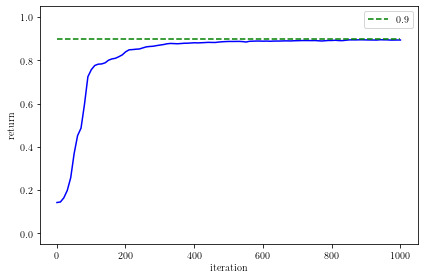

In [13]:
fig, ax = plt.subplots()
ax.plot(iteration_list, return_list)

ax.plot([iteration_list[0], iteration_list[-1]], [0.9, 0.9], label=r"$0.9$")
ax.set_ylabel("return")
ax.set_xlabel("iteration")
ax.set_ylim(-0.05, 1.05)
fig.tight_layout()

ax.legend()

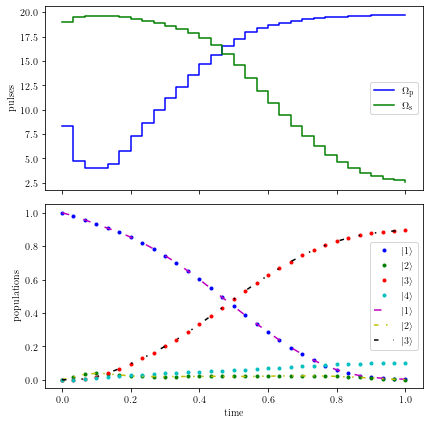

In [11]:
tlist = env_eval_py.tlist
plot_episode(episode_list[-1], tlist, env_py=env_train_py);